# Mount into drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Bil468_Gürcan/Project

Mounted at /content/drive
/content/drive/MyDrive/Bil468_Gürcan/Project


# Load the Dataset

In [ ]:
import os
import cv2
import numpy as np

# Takes folder of images, max_images_per_class to prepare a custom dataset, flatten flag
def load_images_from_folder(folder, max_images_per_class=None, flatten=True):
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_folder_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_folder_path):
            count_images_for_class = 0
            print("label_folder_path: ", label_folder_path)
            for image_file in os.listdir(label_folder_path):
                if max_images_per_class is not None and count_images_for_class >= max_images_per_class:
                    print(f"Reached maximum number of images for class {label_folder}. Skipping the rest.")
                    break
                count_images_for_class += 1
                image_path = os.path.join(label_folder_path, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (48, 48))
                if flatten:
                    images.append(img.flatten())
                else:
                    images.append(img)
                labels.append(label_folder)
    return np.array(images), np.array(labels)

In [ ]:
def prepare_X_y(dataset_name = 'fer2013', max_images_per_class=None, flatten = False):
    if dataset_name == 'fer2013':
        train_folder = './Data/fer2013/train'
        test_folder = './Data/fer2013/validation'
    else:
        train_folder = './Data/Expw-F_sample500/train'
        test_folder = './Data/Expw-F_sample500/validation'
    images_train, labels_train = load_images_from_folder(train_folder, max_images_per_class, flatten=flatten)
    images_test, labels_test = load_images_from_folder(test_folder, max_images_per_class, flatten=flatten)
    X = np.concatenate((images_train, images_test), axis=0)
    y = np.concatenate((labels_train, labels_test), axis=0)
    return X, y

In [ ]:
X, y = prepare_X_y(dataset_name='fer2013', max_images_per_class=None, flatten = False)

label_folder_path:  ./Data/fer2013/train/happy
label_folder_path:  ./Data/fer2013/train/sad
label_folder_path:  ./Data/fer2013/train/fear
label_folder_path:  ./Data/fer2013/train/surprise
label_folder_path:  ./Data/fer2013/train/neutral
label_folder_path:  ./Data/fer2013/train/angry
label_folder_path:  ./Data/fer2013/train/disgust
label_folder_path:  ./Data/fer2013/validation/angry
label_folder_path:  ./Data/fer2013/validation/disgust
label_folder_path:  ./Data/fer2013/validation/neutral
label_folder_path:  ./Data/fer2013/validation/surprise
label_folder_path:  ./Data/fer2013/validation/happy
label_folder_path:  ./Data/fer2013/validation/sad
label_folder_path:  ./Data/fer2013/validation/fear


In [ ]:
from collections import Counter
class_counts = Counter(y)
print(class_counts)

Counter({'happy': 8989, 'neutral': 6198, 'sad': 6077, 'angry': 4953, 'fear': 4721, 'surprise': 4002, 'disgust': 547})


# One Hot Encode Expression Labels

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(y)

label_dict = {k: v for k, v in enumerate(lb.classes_)}
print(label_dict)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


# Train - Test Split with stratify parameter to have balanced distribution
#### 80% train / 10% validation / 10% test

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split
X_reshaped = X.reshape((X.shape[0], 48, 48, 1))

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, test_size=0.1, shuffle=True, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1/9), shuffle=True, stratify=y_train)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
class_counts_train = Counter(np.argmax(y_train , axis = 1 ))
class_counts_val = Counter(np.argmax(y_val , axis = 1 ))
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print(" train: ", class_counts_train,"\n val: ", class_counts_val, "\n test: ", class_counts_test)

(28389, 48, 48, 1)
(3549, 48, 48, 1)
(3549, 48, 48, 1)
 train:  Counter({3: 7191, 4: 4958, 5: 4861, 0: 3963, 2: 3777, 6: 3202, 1: 437}) 
 val:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55}) 
 test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


# Normalization

In [ ]:
X_train_norm = X_train / 255.
X_val_norm = X_val / 255.
X_test_norm = X_test / 255.

In [ ]:
import tensorflow as tf
X_train_tensor = tf.convert_to_tensor(X_train_norm, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val_norm, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_norm, dtype=tf.float32)
X_train_rgb = tf.image.grayscale_to_rgb(X_train_tensor)
X_val_rgb = tf.image.grayscale_to_rgb(X_val_tensor)
X_test_rgb = tf.image.grayscale_to_rgb(X_test_tensor)

# Data Augmentation

In [ ]:
batch_size = 256
epochs = 50

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range = 15,
                              width_shift_range = 0.15,
                              height_shift_range = 0.15,
                              shear_range = 0.15,
                              zoom_range = 0.15,
                              horizontal_flip = True,
                              vertical_flip = False
                            )
datagen.fit(X_train_rgb)

In [ ]:
train_generator = datagen.flow(X_train_rgb, y_train, batch_size=batch_size)

# Preparing Model - VGG19

In [ ]:
from keras.applications import VGG19
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam

number_of_classes = 7
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
head=vgg.layers[-2].output
head=GlobalAveragePooling2D()(head)
head=Dense(number_of_classes, activation='softmax', name='output_layer')(head)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy'])


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

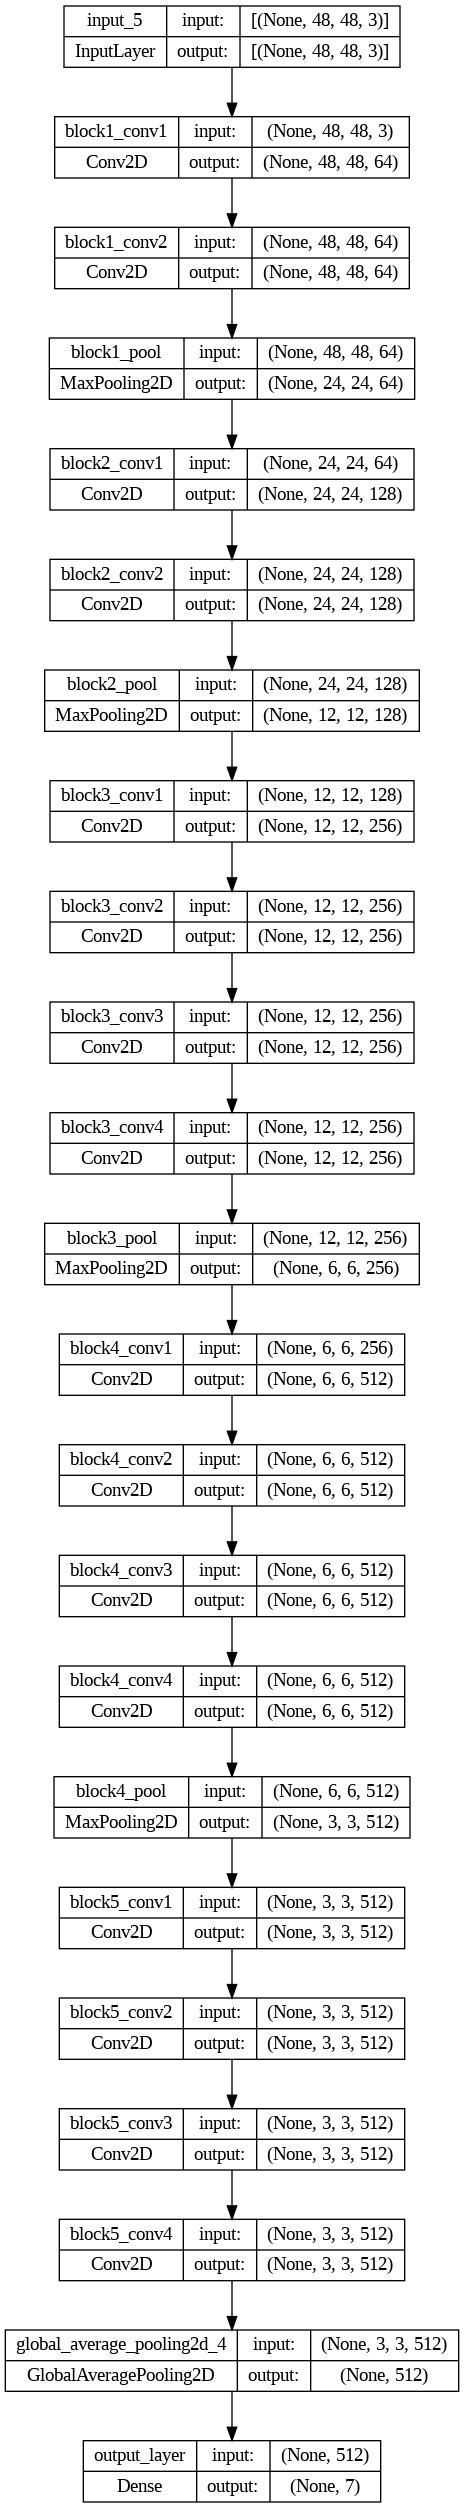

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='vgg19_model_1.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 5, verbose = 1, restore_best_weights = True)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.5, patience = 3, min_lr = 1e-7, verbose = 1)
checkpoint = ModelCheckpoint('best_vgg19_model.h5', monitor="val_accuracy",verbose=1,
                                save_best_only=True, mode="max")
callbacks = [early_stopping,lr_scheduler, checkpoint]

In [ ]:
history_vgg19 = model.fit(train_generator,
                          validation_data = (X_val_rgb, y_val),
                          steps_per_epoch = len(X_train) / batch_size,
                          epochs = epochs,
                          callbacks = callbacks,
                          use_multiprocessing = True)

Epoch 1/50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


111/110 [==============================] - ETA: 0s - loss: 1.6380 - accuracy: 0.3456
Epoch 1: val_accuracy improved from -inf to 0.46999, saving model to best_vgg19_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 69s 491ms/step - loss: 1.6380 - accuracy: 0.3456 - val_loss: 1.3937 - val_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 2/50
111/110 [==============================] - ETA: 0s - loss: 1.3246 - accuracy: 0.4962
Epoch 2: val_accuracy improved from 0.46999 to 0.54889, saving model to best_vgg19_model.h5
110/110 [==============================] - 57s 509ms/step - loss: 1.3246 - accuracy: 0.4962 - val_loss: 1.1858 - val_accuracy: 0.5489 - lr: 1.0000e-04
Epoch 3/50
111/110 [==============================] - ETA: 0s - loss: 1.2054 - accuracy: 0.5403
Epoch 3: val_accuracy improved from 0.54889 to 0.56748, saving model to best_vgg19_model.h5
110/110 [==============================] - 57s 512ms/step - loss: 1.2054 - accuracy: 0.5403 - val_loss: 1.1266 - val_accuracy: 0.5675 - lr: 1.0000e-04
Epoch 4/50
111/110 [==============================] - ETA: 0s - loss: 1.1304 - accuracy: 0.5718
Epoch 4: val_accuracy improved from 0.56748 to 0.59510, saving model to bes

In [ ]:
loss_train = model.evaluate(X_train_rgb, y_train)
loss_val = model.evaluate(X_val_rgb, y_val)
loss_test = model.evaluate(X_test_rgb, y_test)

print("Train Acc: " + str(loss_train[1]), "Val Acc: " + str(loss_val[1]), "Test Acc: " + str(loss_test[1]))

111/111 [==============================] - 1s 7ms/step - loss: 1.0411 - accuracy: 0.6675
Train Acc: 0.8377188444137573 Val Acc: 0.672583818435669 Test Acc: 0.6675119996070862


## Visualize Results - VGG19

In [ ]:
import matplotlib.pyplot as plt

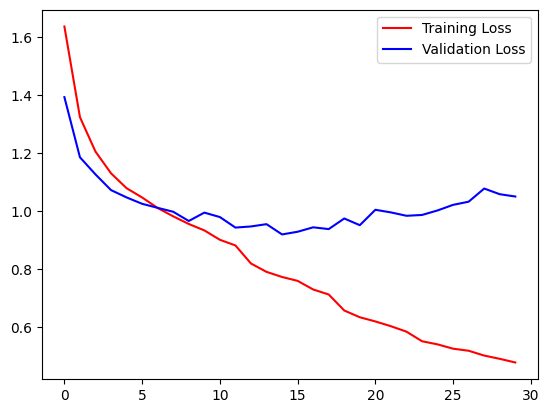

In [ ]:
plt.plot(history_vgg19.history["loss"],'r', label="Training Loss")
plt.plot(history_vgg19.history["val_loss"],'b', label="Validation Loss")
plt.legend()

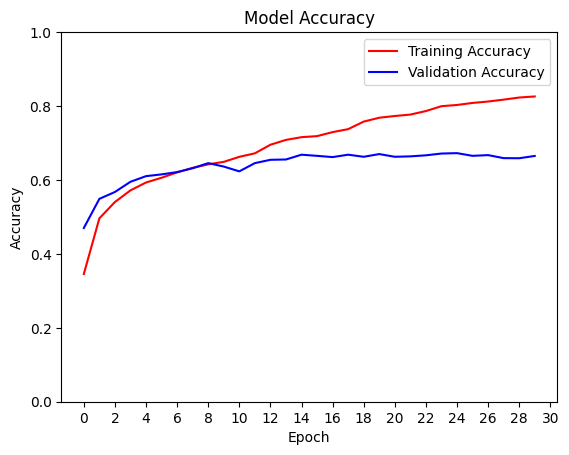

In [ ]:
early_stop_epochs = 30
plt.plot(history_vgg19.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history_vgg19.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, early_stop_epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [ ]:
preds = model.predict(X_test_rgb)
y_pred_vgg19 = np.argmax(preds , axis = 1 )

111/111 [==============================] - 2s 9ms/step


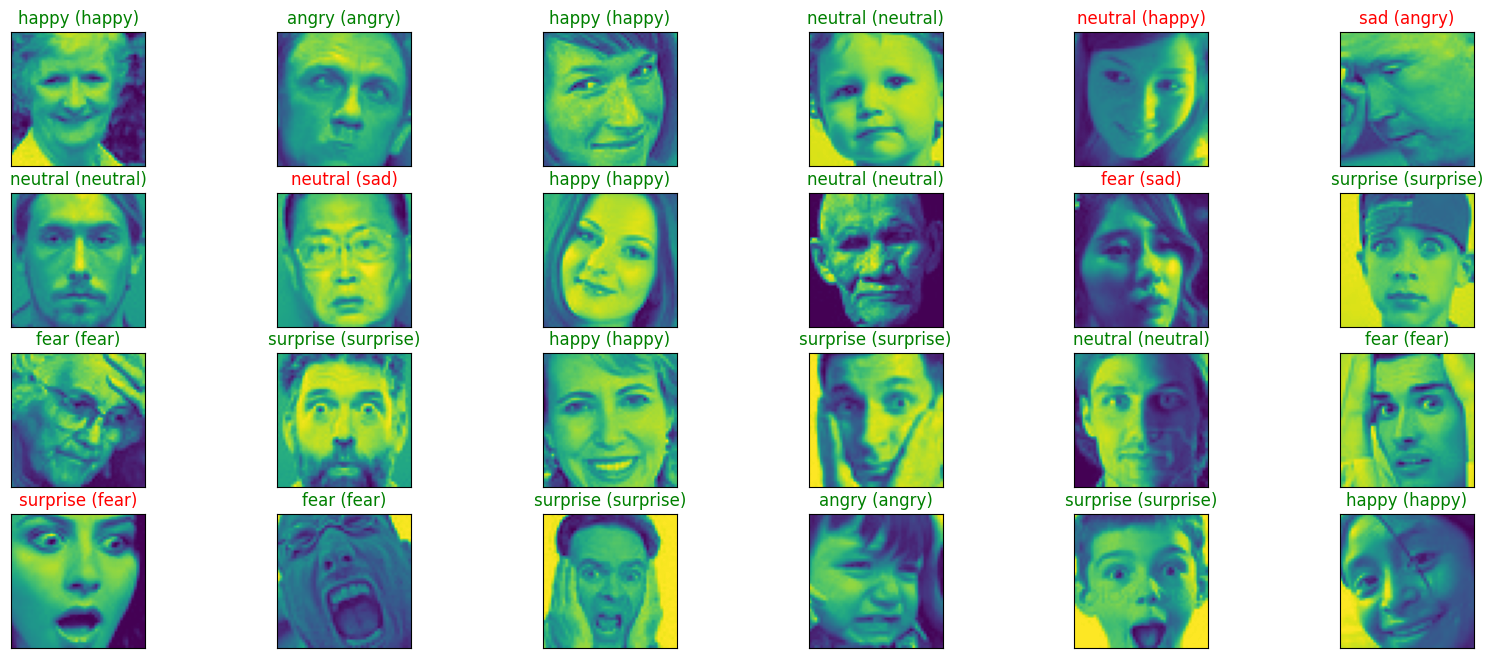

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred_vgg19[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

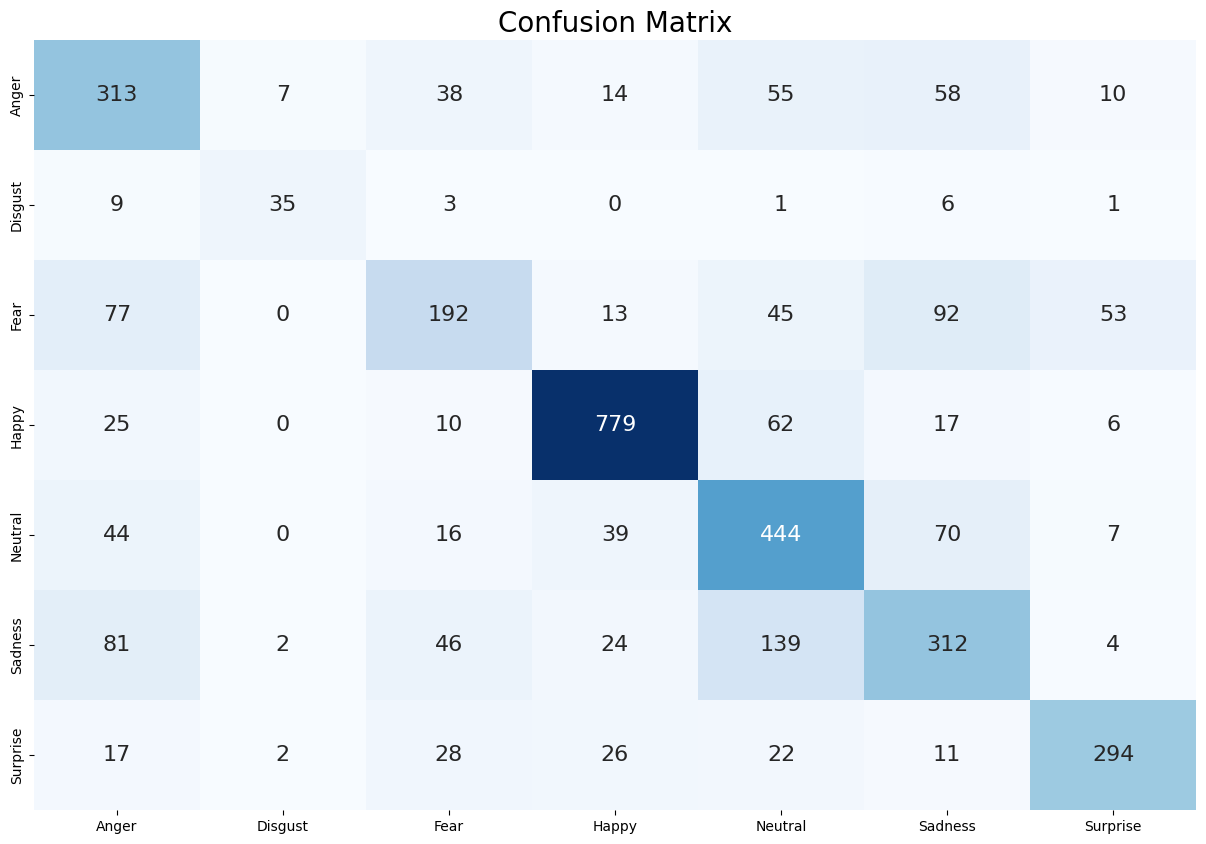

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred_vgg19, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


## Less Epoch for Performance

In [ ]:
from keras.applications import VGG19
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam

number_of_classes = 7
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
head=vgg.layers[-2].output
head=GlobalAveragePooling2D()(head)
head=Dense(number_of_classes, activation='softmax', name='output_layer')(head)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy'])


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 5, verbose = 1, restore_best_weights = True)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.5, patience = 3, min_lr = 1e-7, verbose = 1)
checkpoint = ModelCheckpoint('best_vgg19_model_less_epoch.h5', monitor="val_accuracy",verbose=1,
                                save_best_only=True, mode="max")
callbacks = [early_stopping,lr_scheduler, checkpoint]

less_epochs = 12
history_vgg19 = model.fit(train_generator,
                          validation_data = (X_val_rgb, y_val),
                          steps_per_epoch = len(X_train) / batch_size,
                          epochs = less_epochs,
                          callbacks = callbacks,
                          use_multiprocessing = True)

Epoch 1/12


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


110/110 [============================>.] - ETA: 0s - loss: 1.5178 - accuracy: 0.4052

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


111/110 [==============================] - ETA: 0s - loss: 1.5160 - accuracy: 0.4063
Epoch 1: val_accuracy improved from -inf to 0.51141, saving model to best_vgg19_model_less_epoch.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 63s 427ms/step - loss: 1.5160 - accuracy: 0.4063 - val_loss: 1.2566 - val_accuracy: 0.5114 - lr: 1.0000e-04
Epoch 2/12
111/110 [==============================] - ETA: 0s - loss: 1.2539 - accuracy: 0.5223
Epoch 2: val_accuracy improved from 0.51141 to 0.55114, saving model to best_vgg19_model_less_epoch.h5
110/110 [==============================] - 56s 502ms/step - loss: 1.2539 - accuracy: 0.5223 - val_loss: 1.1555 - val_accuracy: 0.5511 - lr: 1.0000e-04
Epoch 3/12
111/110 [==============================] - ETA: 0s - loss: 1.1570 - accuracy: 0.5616
Epoch 3: val_accuracy improved from 0.55114 to 0.58552, saving model to best_vgg19_model_less_epoch.h5
110/110 [==============================] - 55s 494ms/step - loss: 1.1570 - accuracy: 0.5616 - val_loss: 1.0899 - val_accuracy: 0.5855 - lr: 1.0000e-04
Epoch 4/12
111/110 [==============================] - ETA: 0s - loss: 1.1113 - accuracy: 0.5794
Epoch 4: val_accuracy did not improve from 0.58552
11

In [ ]:
import matplotlib.pyplot as plt

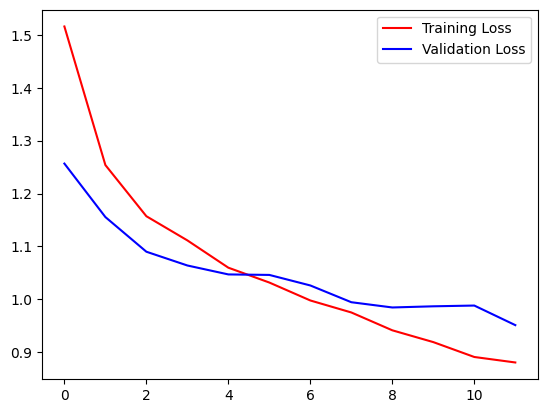

In [ ]:
plt.plot(history_vgg19.history["loss"],'r', label="Training Loss")
plt.plot(history_vgg19.history["val_loss"],'b', label="Validation Loss")
plt.legend()

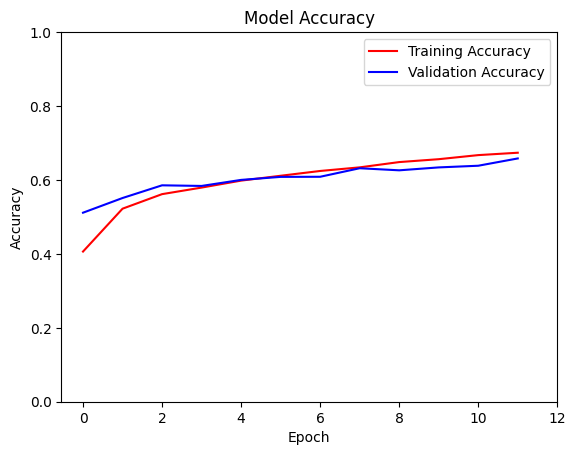

In [ ]:
early_stop_epochs = 12
plt.plot(history_vgg19.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history_vgg19.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, early_stop_epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [ ]:
preds = model.predict(X_test_rgb)
y_pred_vgg19 = np.argmax(preds , axis = 1 )

111/111 [==============================] - 1s 6ms/step


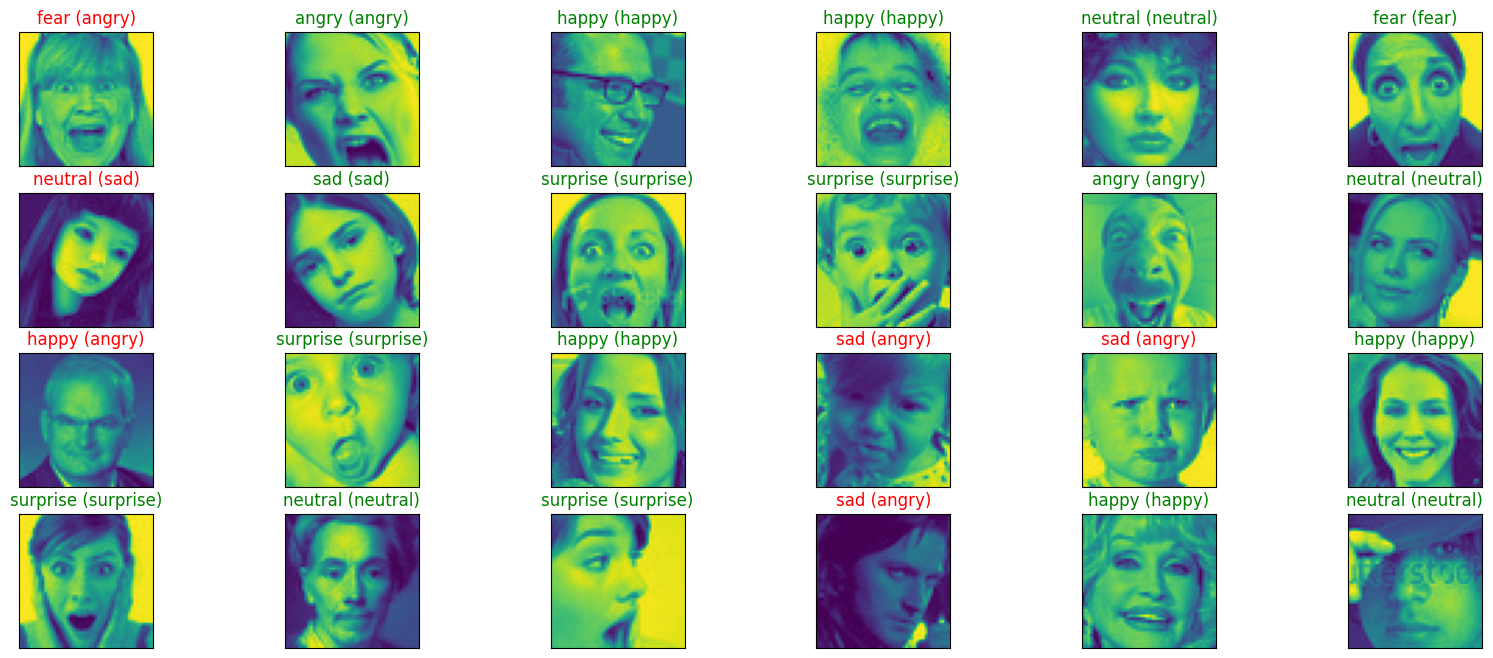

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred_vgg19[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

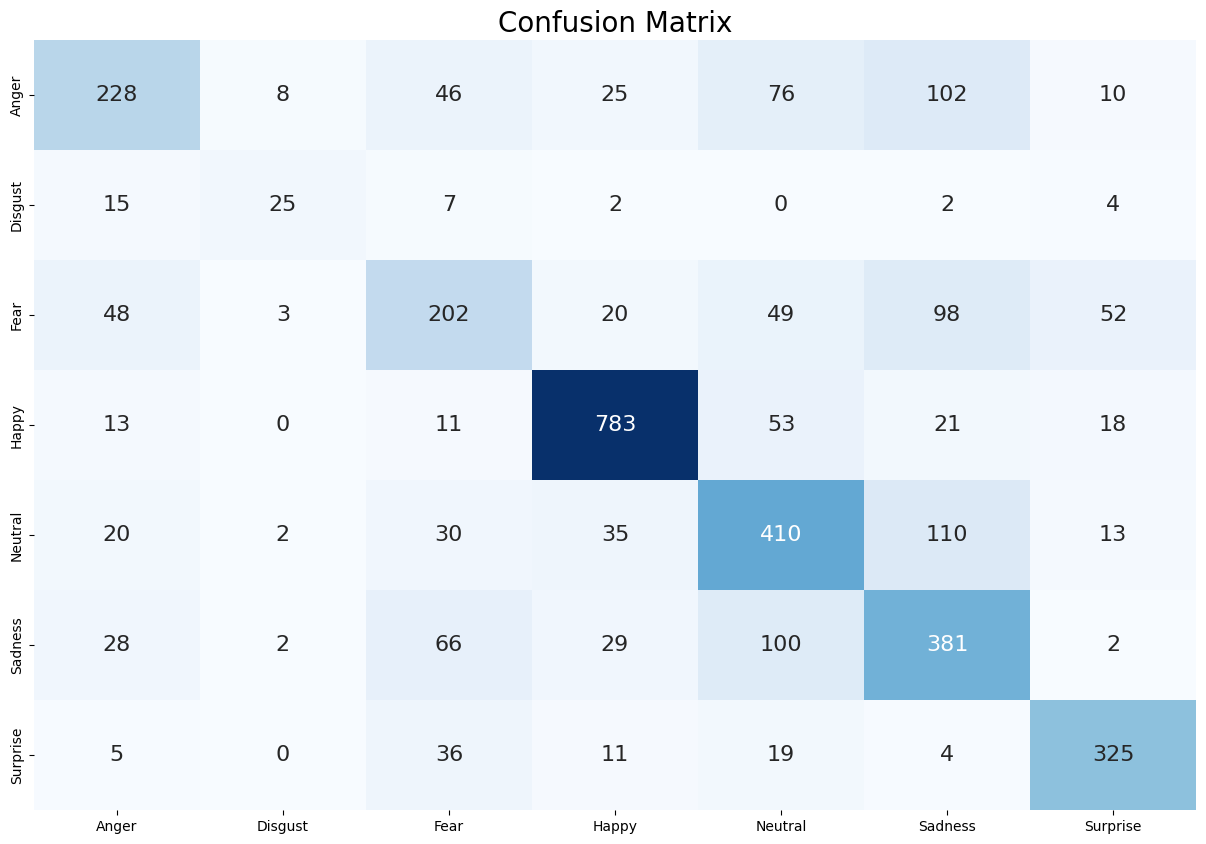

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred_vgg19, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


# Preparing Model - ResNet50

In [ ]:
from keras.applications import ResNet50

number_of_classes = 7
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
head=resnet50.layers[-2].output
head=GlobalAveragePooling2D()(head)
head=Dense(number_of_classes, activation='softmax', name='output_layer')(head)

model2 = Model(inputs = resnet50.input, outputs = head)

print(model2.summary())

model2.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy', 'Precision', 'Recall'])


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

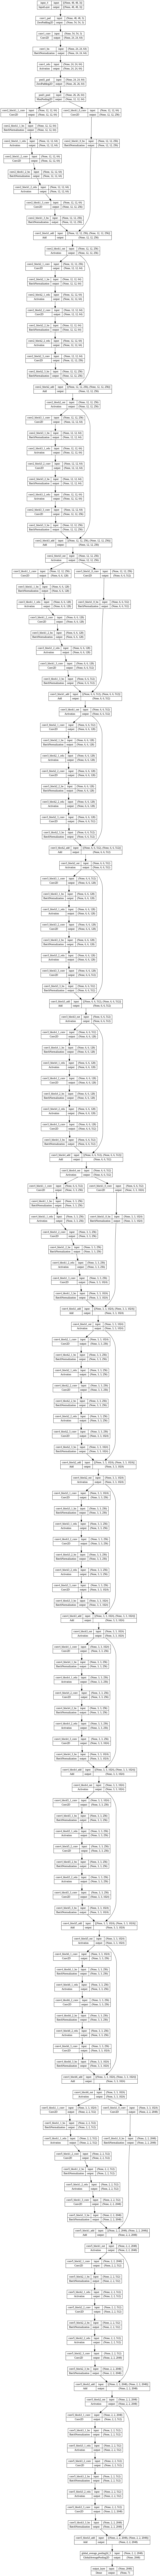

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model2, to_file='resnet_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
epochs = 50
history_resnet50 = model2.fit(train_generator,
                          validation_data = (X_val_rgb, y_val),
                          steps_per_epoch = len(X_train) / batch_size,
                          epochs = epochs,
                          callbacks = callbacks,
                          use_multiprocessing = True)

Epoch 1/50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


110/110 [============================>.] - ETA: 0s - loss: 2.1958 - accuracy: 0.3005 - precision: 0.3597 - recall: 0.1268

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


111/110 [==============================] - ETA: 0s - loss: 2.1905 - accuracy: 0.3013 - precision: 0.3609 - recall: 0.1268
Epoch 1: val_accuracy did not improve from 0.67258
110/110 [==============================] - 95s 487ms/step - loss: 2.1905 - accuracy: 0.3013 - precision: 0.3609 - recall: 0.1268 - val_loss: 39.6377 - val_accuracy: 0.1330 - val_precision: 0.1330 - val_recall: 0.1330 - lr: 1.0000e-04
Epoch 2/50
111/110 [==============================] - ETA: 0s - loss: 1.5833 - accuracy: 0.4163 - precision: 0.6535 - recall: 0.1796
Epoch 2: val_accuracy did not improve from 0.67258
110/110 [==============================] - 62s 557ms/step - loss: 1.5833 - accuracy: 0.4163 - precision: 0.6535 - recall: 0.1796 - val_loss: 30.4273 - val_accuracy: 0.1710 - val_precision: 0.1696 - val_recall: 0.1679 - lr: 1.0000e-04
Epoch 3/50
111/110 [==============================] - ETA: 0s - loss: 1.4454 - accuracy: 0.4658 - precision: 0.6896 - recall: 0.2462
Epoch 3: val_accuracy did not improve from

## Visualize Results - ResNet50

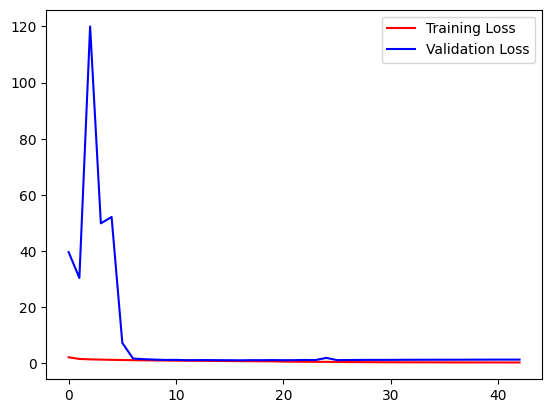

In [ ]:
plt.plot(history_resnet50.history["loss"],'r', label="Training Loss")
plt.plot(history_resnet50.history["val_loss"],'b', label="Validation Loss")
plt.legend()

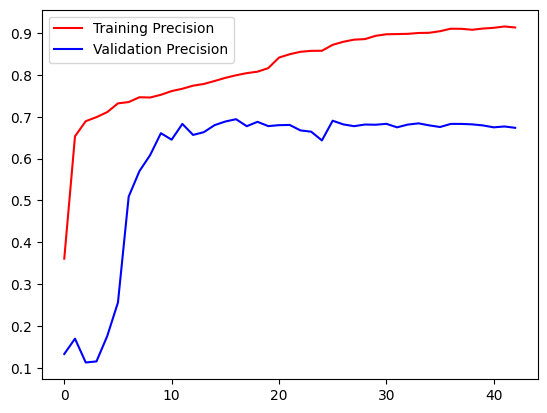

In [ ]:
plt.plot(history_resnet50.history["precision"],'r', label="Training Precision")
plt.plot(history_resnet50.history["val_precision"],'b', label="Validation Precision")
plt.legend()

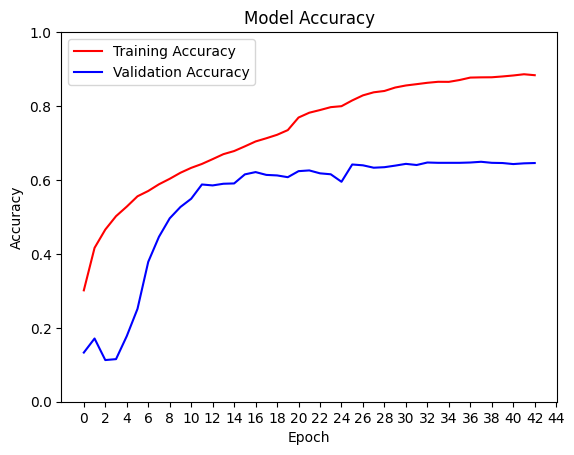

In [ ]:
early_stop_epochs = 44
plt.plot(history_resnet50.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history_resnet50.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, early_stop_epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [ ]:
preds = model2.predict(X_test_rgb)
y_pred_resnet = np.argmax(preds , axis = 1 )

111/111 [==============================] - 6s 17ms/step


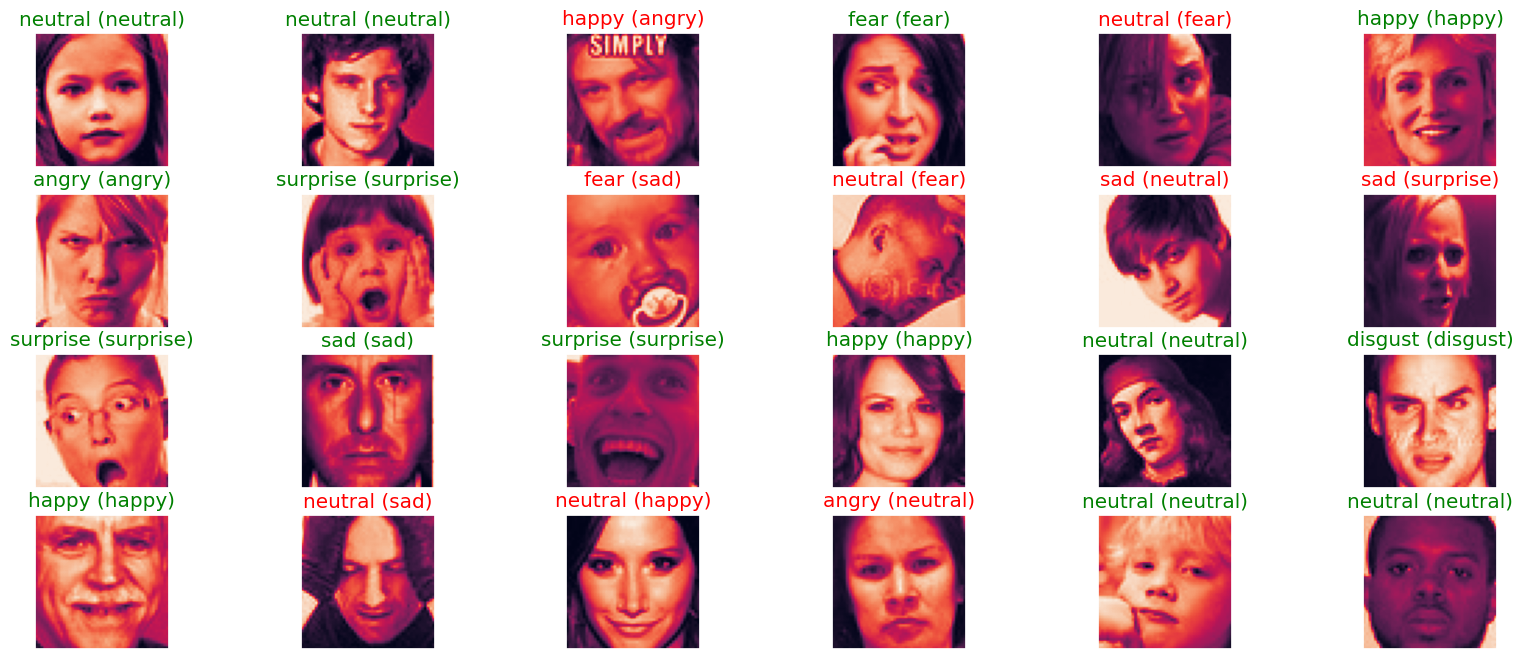

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred_resnet[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

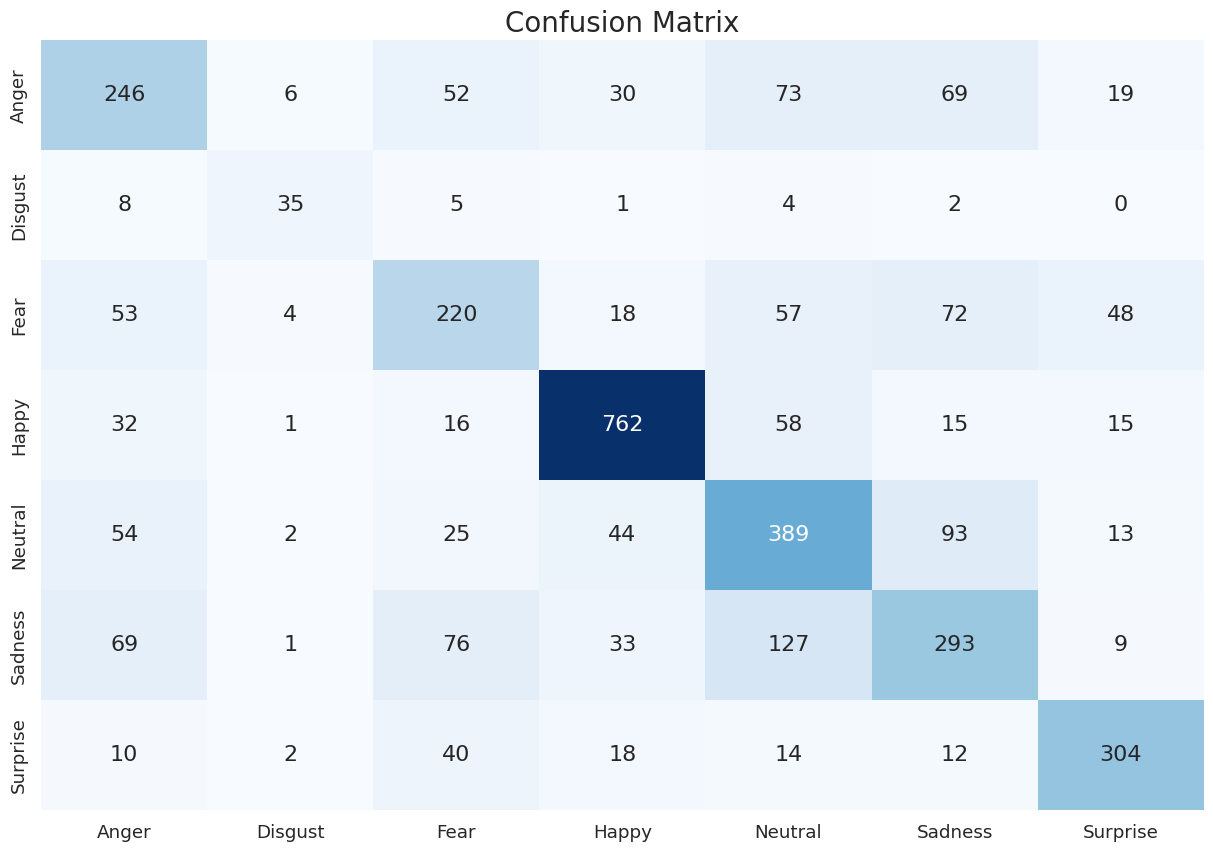

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred_resnet, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


In [ ]:
model2.save('best_resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Preparing Model - Base CNN MORE LAYERS

In [ ]:
from collections import Counter
X_reshaped = X.reshape((X.shape[0], 48, 48, 1))

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, test_size=0.1, shuffle=True, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1/9), shuffle=True, stratify=y_train)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
class_counts_train = Counter(np.argmax(y_train , axis = 1 ))
class_counts_val = Counter(np.argmax(y_val , axis = 1 ))
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print(" train: ", class_counts_train,"\n val: ", class_counts_val, "\n test: ", class_counts_test)

(28389, 48, 48, 1)
(3549, 48, 48, 1)
(3549, 48, 48, 1)
 train:  Counter({3: 7191, 4: 4958, 5: 4861, 0: 3963, 2: 3777, 6: 3202, 1: 437}) 
 val:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55}) 
 test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


In [ ]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True)

In [ ]:
datagen.fit(X_train)
valgen.fit(X_val)

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization

In [ ]:
def build_model():

    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))
    model.compile(
      optimizer = Adam(lr=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
    return model

In [ ]:
model = build_model()
model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model_vanilla_cnn.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
444/444 [==============================] - ETA: 0s - loss: 7.1017 - accuracy: 0.2175 - precision: 0.2351 - recall: 0.0439
Epoch 1: val_accuracy improved from -inf to 0.21781, saving model to best_model_vanilla_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


444/444 [==============================] - 41s 66ms/step - loss: 7.1017 - accuracy: 0.2175 - precision: 0.2351 - recall: 0.0439 - val_loss: 2.7303 - val_accuracy: 0.2178 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
444/444 [==============================] - ETA: 0s - loss: 2.6282 - accuracy: 0.3122 - precision: 0.5315 - recall: 0.0878
Epoch 2: val_accuracy improved from 0.21781 to 0.25866, saving model to best_model_vanilla_cnn.h5
444/444 [==============================] - 25s 56ms/step - loss: 2.6282 - accuracy: 0.3122 - precision: 0.5315 - recall: 0.0878 - val_loss: 2.9315 - val_accuracy: 0.2587 - val_precision: 0.3059 - val_recall: 0.2378
Epoch 3/30
444/444 [==============================] - ETA: 0s - loss: 2.5462 - accuracy: 0.4031 - precision: 0.6978 - recall: 0.1777
Epoch 3: val_accuracy improved from 0.25866 to 0.42209, saving model to best_model_vanilla_cnn.h5
444/444 [==============================] - 44s 100ms/step - loss: 2.5462 - accuracy: 0.4031 - precis

## Visualize Results

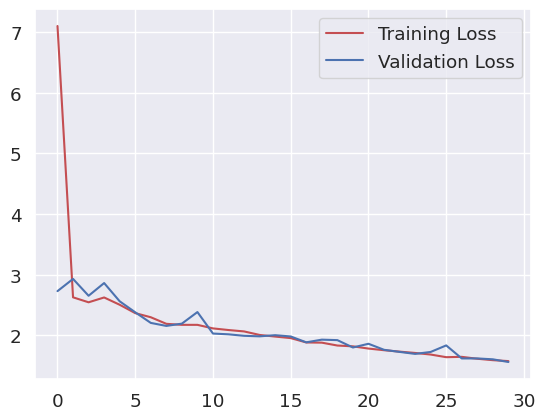

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

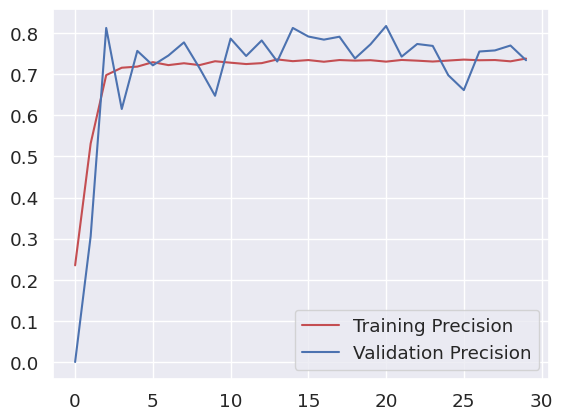

In [ ]:
plt.plot(history.history["precision"],'r', label="Training Precision")
plt.plot(history.history["val_precision"],'b', label="Validation Precision")
plt.legend()

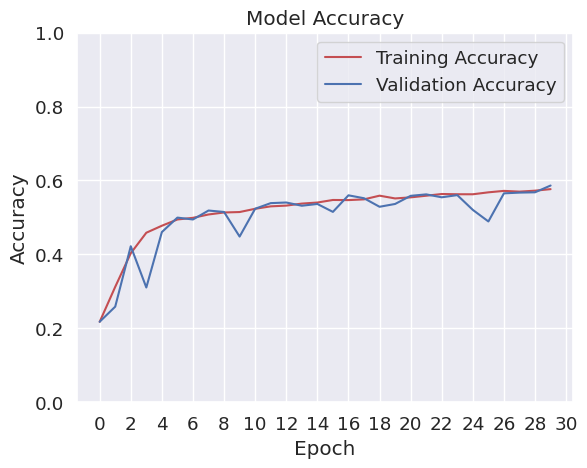

In [ ]:
epochs = 30
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

111/111 [==============================] - 1s 3ms/step


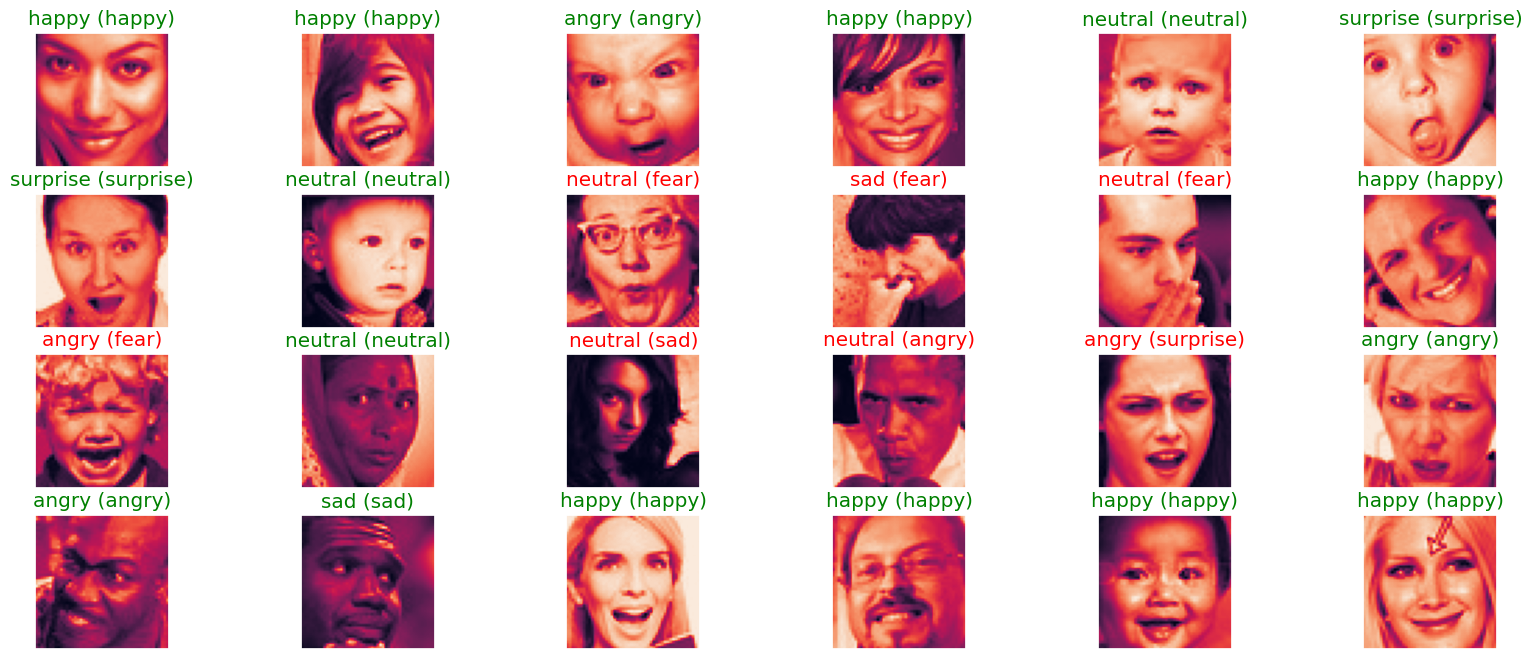

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [ ]:
from collections import Counter
class_counts_predict = Counter(y_pred)
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print("predict: ", class_counts_predict, " test: ", class_counts_test)

predict:  Counter({3: 957, 4: 838, 5: 754, 0: 563, 6: 403, 2: 34})  test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


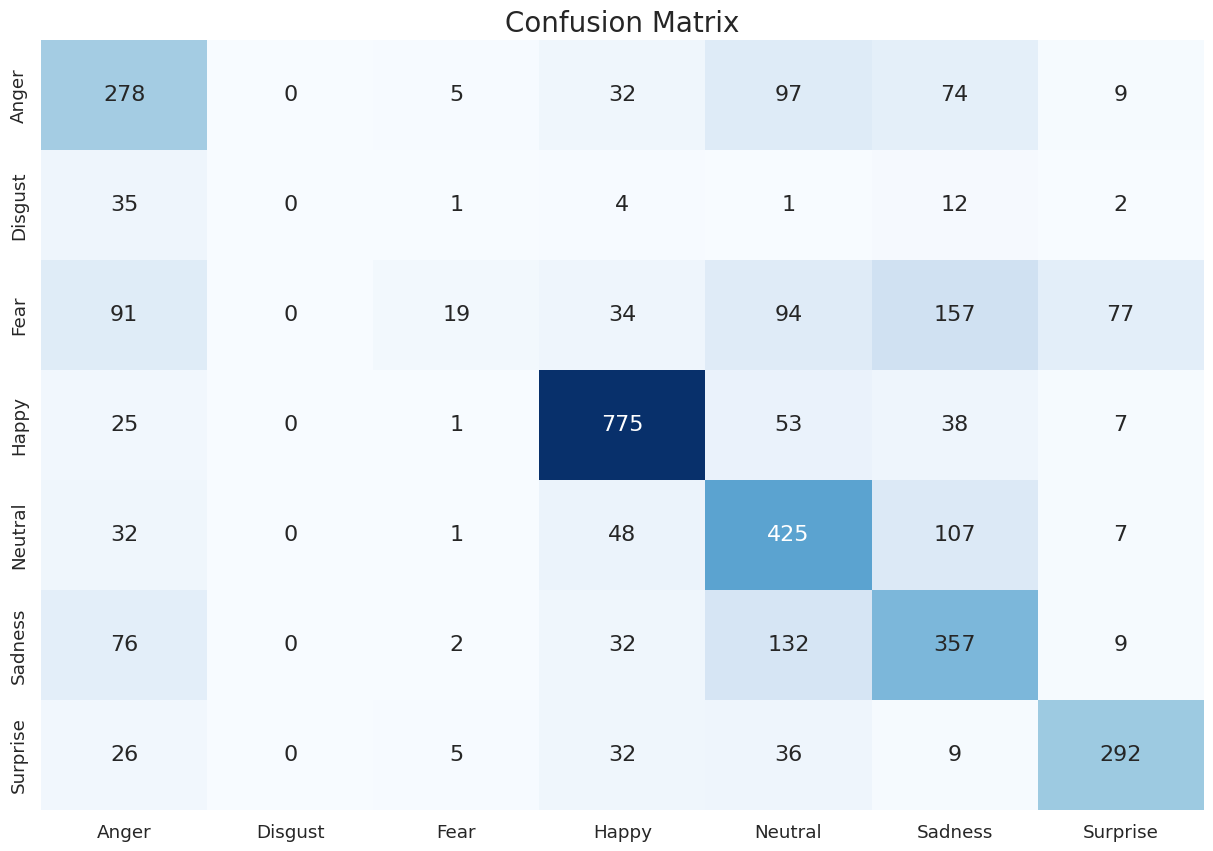

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


In [ ]:
loss_train = model.evaluate(X_train,y_train)
loss_val = model.evaluate(X_val,y_val)
loss_test = model.evaluate(X_test,y_test)
print("Train Acc: " + str(loss_train[1]), "Vall Acc: " + str(loss_val[1]), "Test Acc: " + str(loss_test[1]))

111/111 [==============================] - 1s 6ms/step - loss: 1.5053 - accuracy: 0.6047 - precision: 0.7722 - recall: 0.4193
Train Acc: 0.6113283038139343 Vall Acc: 0.5869259238243103 Test Acc: 0.6046773791313171


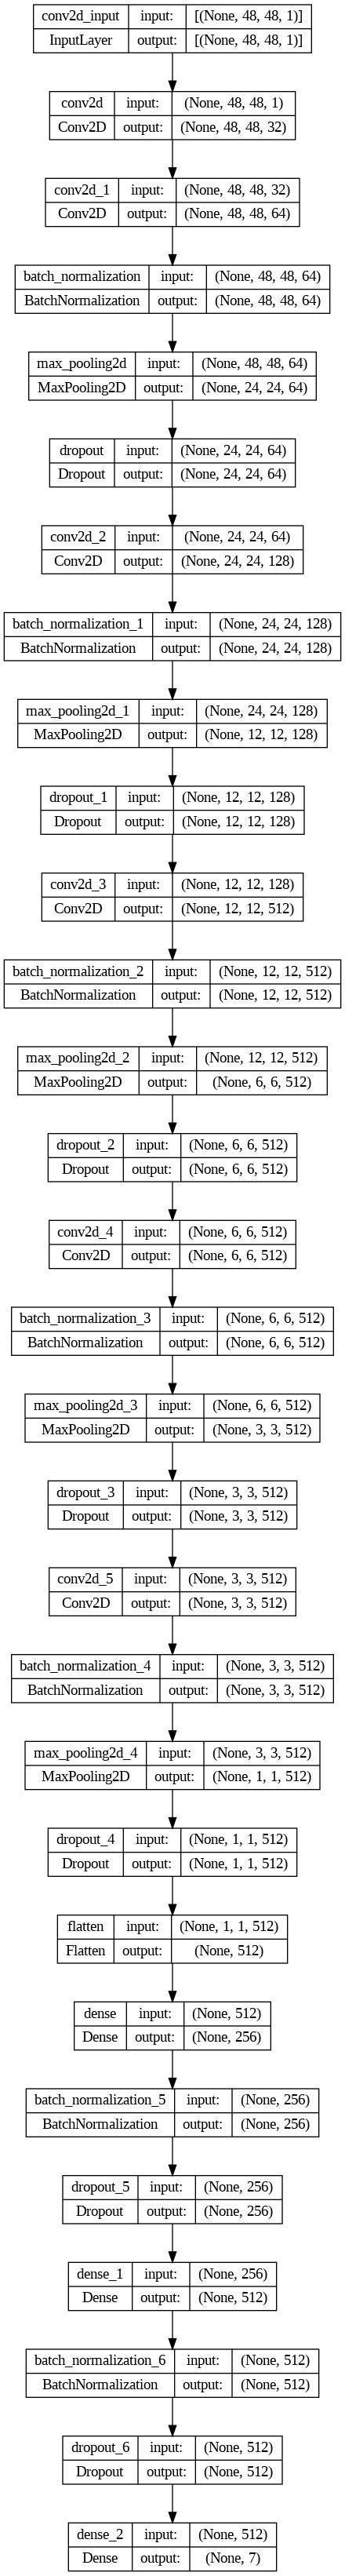

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='base_cnn_model_2.png', show_shapes=True, show_layer_names=True)


# Preparing Model - Base CNN LESS LAYERS

In [ ]:
def build_model_2():

    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
model2 = build_model_2()
model2.compile(
      optimizer = Adam(lr=0.00005),
      loss='categorical_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall'])


In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model_vanilla_cnn_less_layers.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history = model2.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
444/444 [==============================] - ETA: 0s - loss: 2.0377 - accuracy: 0.2680 - precision: 0.3120 - recall: 0.0697
Epoch 1: val_accuracy improved from -inf to 0.32798, saving model to best_model_vanilla_cnn_less_layers.h5
444/444 [==============================] - 25s 46ms/step - loss: 2.0377 - accuracy: 0.2680 - precision: 0.3120 - recall: 0.0697 - val_loss: 1.6593 - val_accuracy: 0.3280 - val_precision: 0.5495 - val_recall: 0.1203
Epoch 2/30
  1/444 [..............................] - ETA: 24s - loss: 1.6935 - accuracy: 0.3125 - precision: 0.6154 - recall: 0.1250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


443/444 [============================>.] - ETA: 0s - loss: 1.6538 - accuracy: 0.3647 - precision: 0.5747 - recall: 0.1261
Epoch 2: val_accuracy improved from 0.32798 to 0.38687, saving model to best_model_vanilla_cnn_less_layers.h5
444/444 [==============================] - 21s 47ms/step - loss: 1.6534 - accuracy: 0.3650 - precision: 0.5752 - recall: 0.1261 - val_loss: 1.5992 - val_accuracy: 0.3869 - val_precision: 0.6129 - val_recall: 0.1530
Epoch 3/30
444/444 [==============================] - ETA: 0s - loss: 1.4961 - accuracy: 0.4222 - precision: 0.6921 - recall: 0.1747
Epoch 3: val_accuracy improved from 0.38687 to 0.44125, saving model to best_model_vanilla_cnn_less_layers.h5
444/444 [==============================] - 21s 47ms/step - loss: 1.4961 - accuracy: 0.4222 - precision: 0.6921 - recall: 0.1747 - val_loss: 1.4536 - val_accuracy: 0.4413 - val_precision: 0.8186 - val_recall: 0.1589
Epoch 4/30
444/444 [==============================] - ETA: 0s - loss: 1.4260 - accuracy: 0.4519

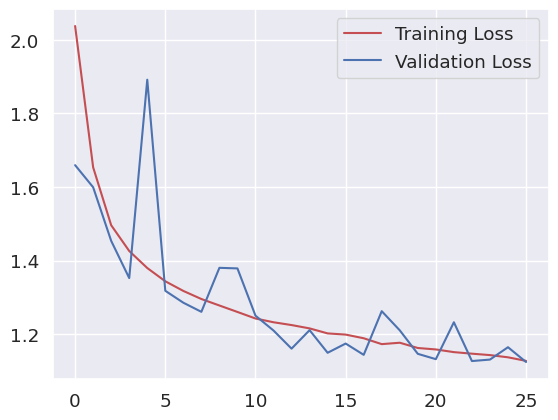

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

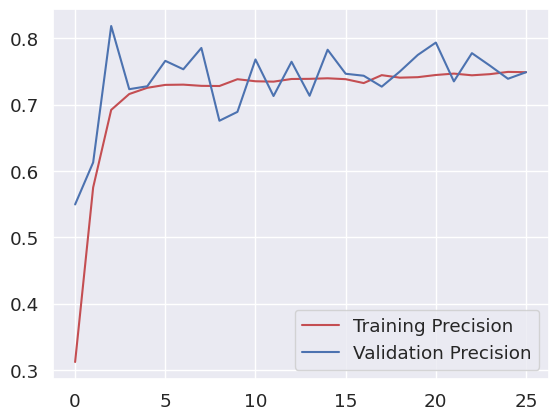

In [ ]:
plt.plot(history.history["precision"],'r', label="Training Precision")
plt.plot(history.history["val_precision"],'b', label="Validation Precision")
plt.legend()

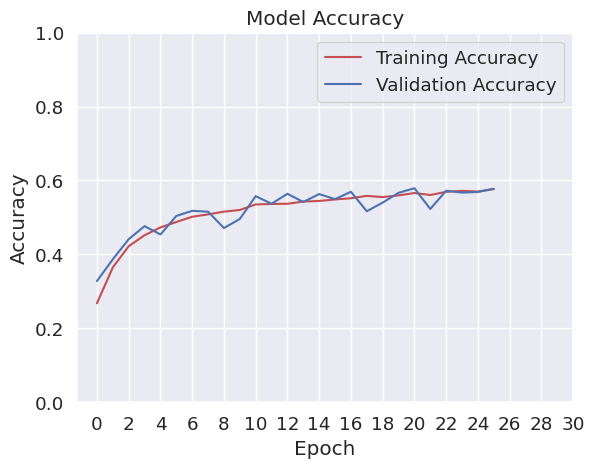

In [ ]:
epochs = 30
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [ ]:
preds = model2.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

111/111 [==============================] - 0s 2ms/step


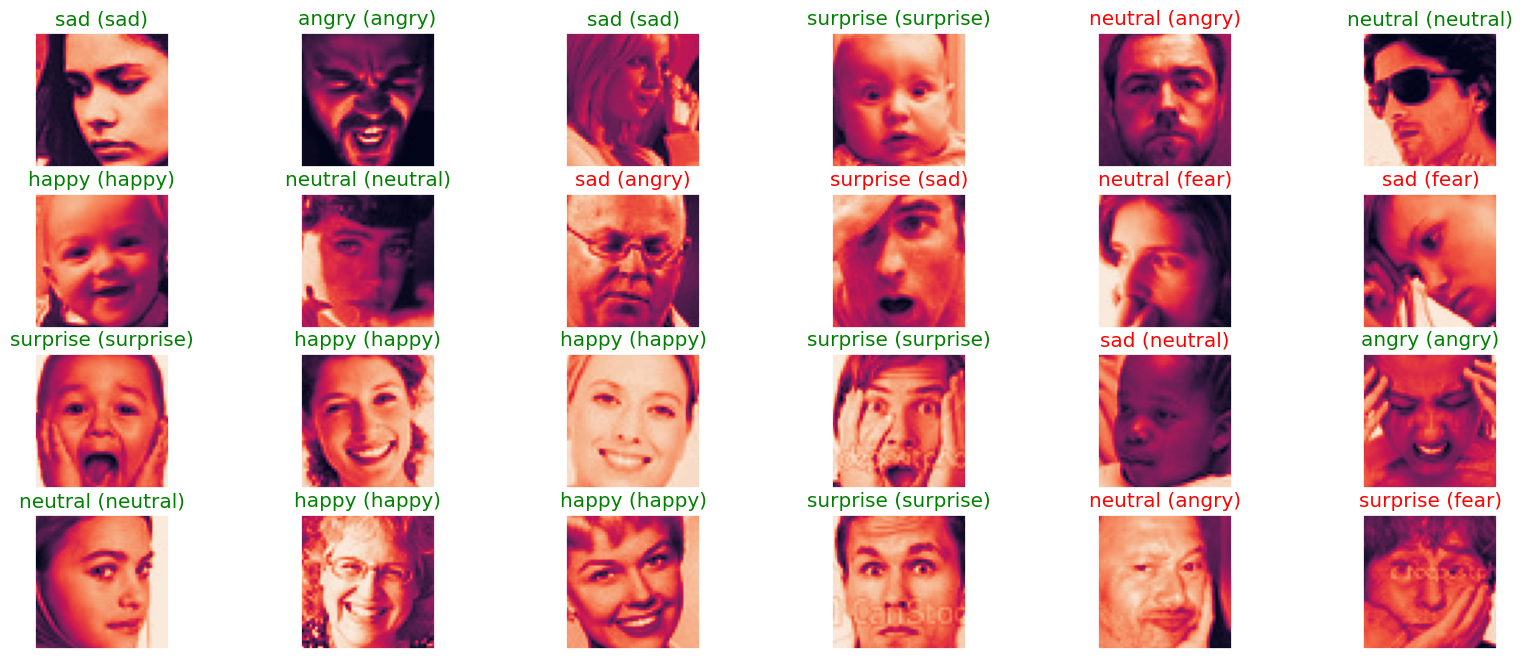

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [ ]:
from collections import Counter
class_counts_predict = Counter(y_pred)
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print("predict: ", class_counts_predict, " test: ", class_counts_test)

predict:  Counter({3: 1003, 4: 849, 5: 588, 6: 493, 0: 344, 2: 241, 1: 31})  test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


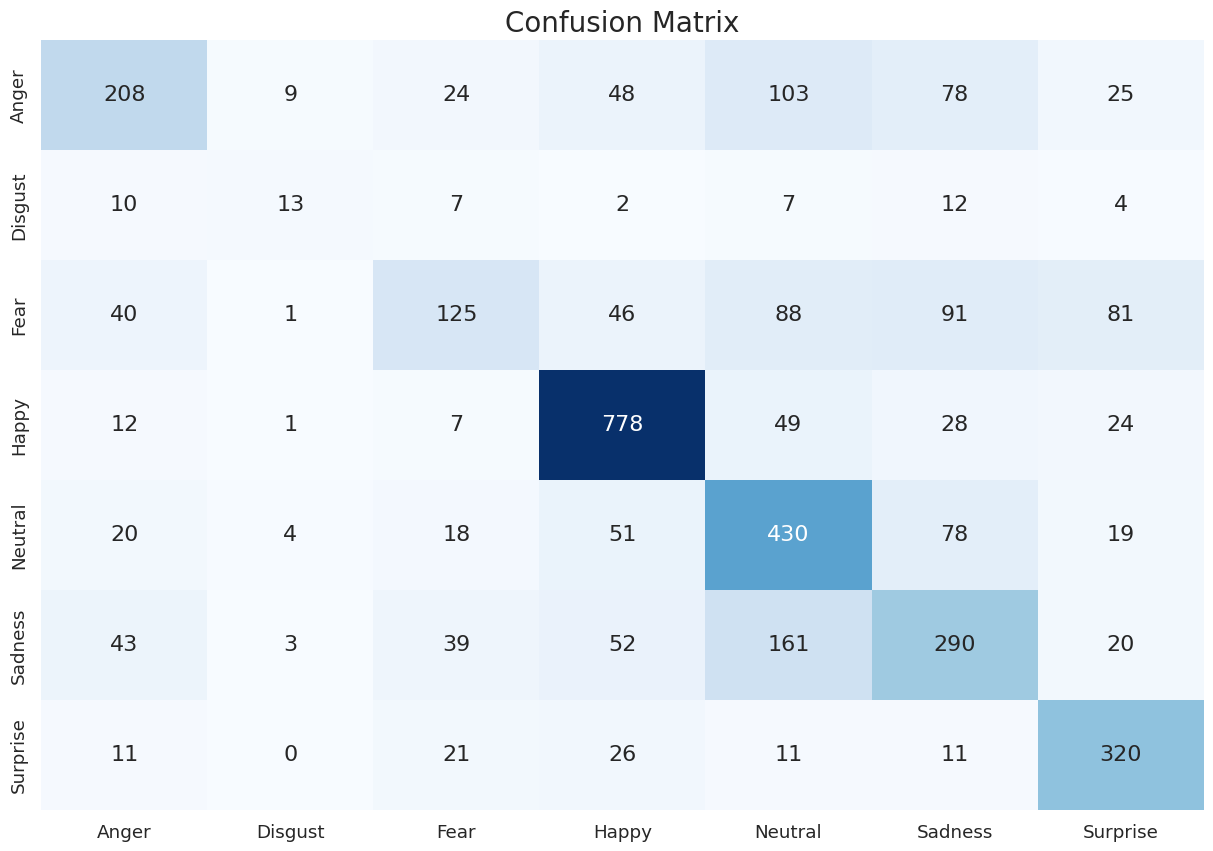

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


In [ ]:
loss_train = model2.evaluate(X_train,y_train)
loss_val = model2.evaluate(X_val,y_val)
loss_test = model2.evaluate(X_test,y_test)
print("Train Acc: " + str(loss_train[1]), "Vall Acc: " + str(loss_val[1]), "Test Acc: " + str(loss_test[1]))

111/111 [==============================] - 1s 7ms/step - loss: 1.0483 - accuracy: 0.6097 - precision: 0.7936 - recall: 0.4117
Train Acc: 0.6240797638893127 Vall Acc: 0.5979149341583252 Test Acc: 0.6097491979598999


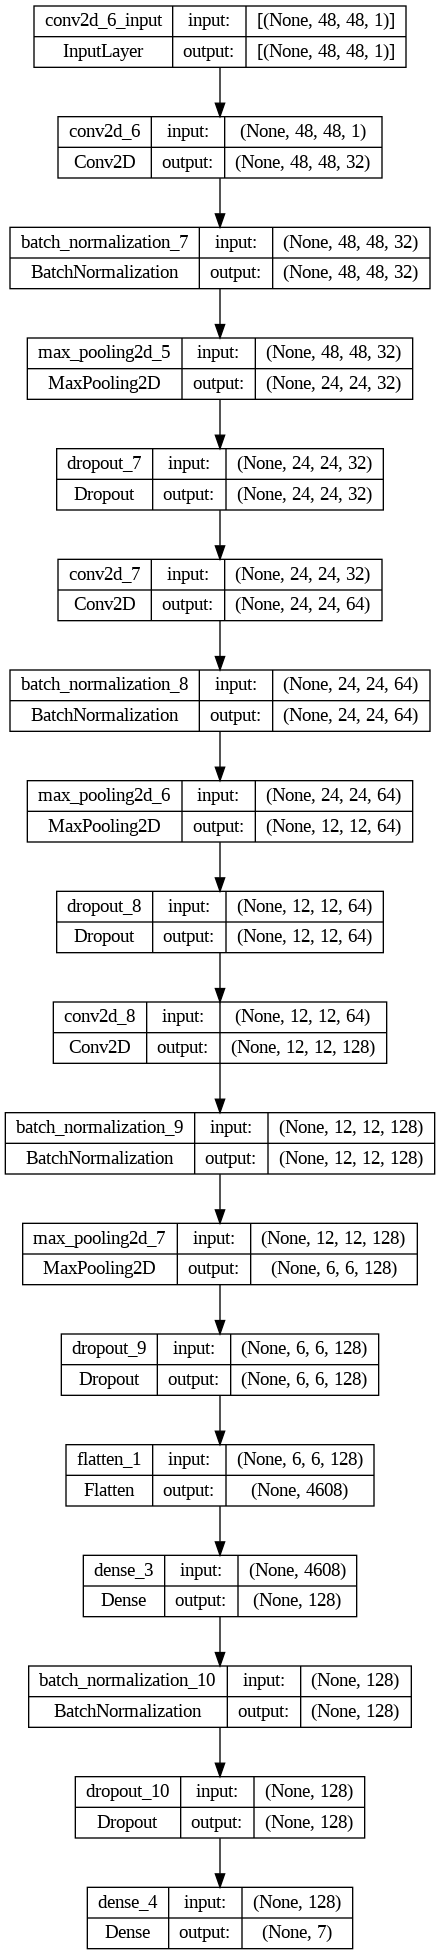

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model2, to_file='base_cnn_model_2.png', show_shapes=True, show_layer_names=True)
